In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/BHBikash/FinalDataset/main/Dataset%20O2N.csv')

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=True, inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [ ]:
train_size = int(len(scaled_data) * 0.99)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Equations: L_D = -[log(D(x)) + log(1 - D(G(z)))]
L_G = -log(D(G(z)))

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=1, batch_size=32)

79/79 [==============================] - 11s 41ms/step - loss: 0.0088


In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
pred_df = pd.DataFrame({'Date': data.index[train_size+sequence_length:], 'Forecasted Price': y_pred.flatten()})

In [ ]:
print("Predicted Values:")
print(pred_df)
print("\nMean Squared Error:", mse)
print("RMSE:", rmse)
print("Mean Absolute Error:", mae)

Predicted Values:
         Date  Forecasted Price
0  2023-05-25        110.062782
1  2023-05-26        110.069633
2  2023-05-29        110.069588
3  2023-05-30        109.975525
4  2023-05-31        109.962868
5  2023-06-01        109.948631
6  2023-06-02        109.947128
7  2023-06-05        109.932693
8  2023-06-06        109.943275
9  2023-06-07        109.860954
10 2023-06-08        109.899734
11 2023-06-09        109.962433
12 2023-06-12        110.039650
13 2023-06-13        110.144516
14 2023-06-14        110.260788
15 2023-06-15        110.414368

Mean Squared Error: 5.3890839088555005
RMSE: 2.3214400506701653
Mean Absolute Error: 2.257597991943358


In [ ]:
merged_df = pd.merge(data, pred_df, on='Date', how='inner')

In [ ]:
merged_df['Difference'] = merged_df['Price'] - merged_df['Forecasted Price']

In [ ]:
print(merged_df[['Date', 'Price', 'Forecasted Price', 'Difference']])

         Date    Price  Forecasted Price  Difference
0  2023-05-25  107.160        110.062782   -2.902782
1  2023-05-26  107.205        110.069633   -2.864633
2  2023-05-29  107.180        110.069588   -2.889588
3  2023-05-30  107.240        109.975525   -2.735525
4  2023-05-31  107.200        109.962868   -2.762868
5  2023-06-01  107.230        109.948631   -2.718631
6  2023-06-02  107.295        109.947128   -2.652128
7  2023-06-05  107.680        109.932693   -2.252693
8  2023-06-06  107.870        109.943275   -2.073275
9  2023-06-07  107.920        109.860954   -1.940954
10 2023-06-08  108.210        109.899734   -1.689734
11 2023-06-09  108.193        109.962433   -1.769433
12 2023-06-12  108.290        110.039650   -1.749650
13 2023-06-13  108.250        110.144516   -1.894516
14 2023-06-14  109.250        110.260788   -1.010788
15 2023-06-15  108.200        110.414368   -2.214368


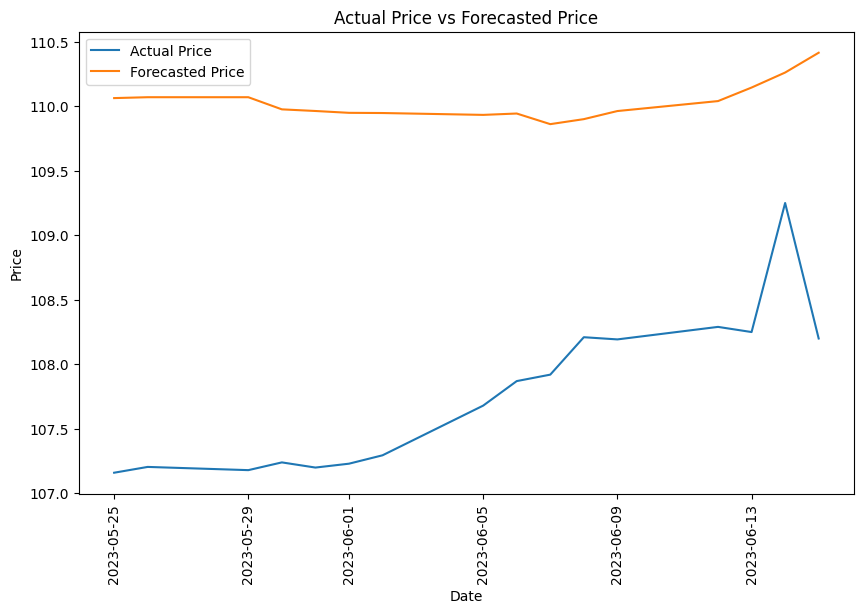

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Price'], label='Actual Price')
plt.plot(merged_df['Date'], merged_df['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Price vs Forecasted Price')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('gansgraph.png', dpi=300)
plt.show()

In [ ]:
last_sequence = scaled_data[-sequence_length:]

In [ ]:
future_predictions = []

In [ ]:
for _ in range(180):
    next_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_prediction[0][0])
    last_sequence = np.append(last_sequence[1:], next_prediction[0])

1/1 [==============================] - 0s 23ms/step


In [ ]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [ ]:
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=180, freq='D')

In [ ]:
future_df = pd.DataFrame({'Date': future_dates, 'Forecasted Price': future_predictions.flatten()})

In [ ]:
future_df['Date'] = pd.to_datetime(future_df['Date'])

In [ ]:
print("Future Predictions:")
print(future_df)

Future Predictions:
          Date  Forecasted Price
0   2023-06-16        110.584435
1   2023-06-17        110.784081
2   2023-06-18        110.970535
3   2023-06-19        111.185562
4   2023-06-20        111.457848
..         ...               ...
175 2023-12-08        127.727310
176 2023-12-09        127.727600
177 2023-12-10        127.727913
178 2023-12-11        127.728180
179 2023-12-12        127.728439

[180 rows x 2 columns]


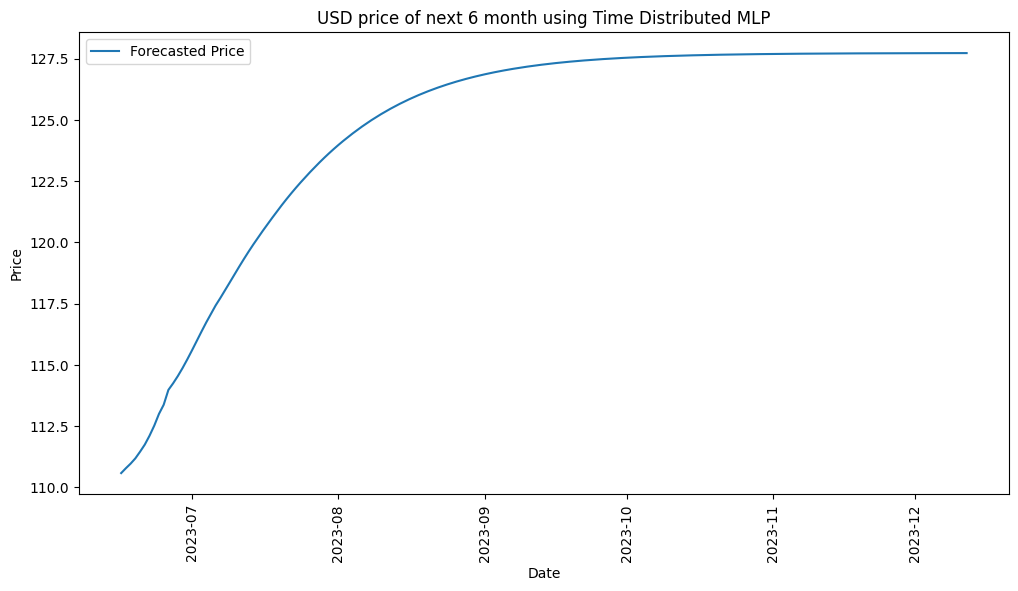

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(future_df['Date'], future_df['Forecasted Price'], label='Forecasted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('USD price of next 6 month using Time Distributed MLP')
plt.legend()
plt.xticks(rotation=90)
plt.show()